# School Performance and Socioeconomic Factors: A Predictive Analysis

## Introduction

### Research Question
This analysis investigates whether **school performance, measured by average ACT scores, is predicted by socioeconomic factors**. Educational achievement gaps have long been a concern in the United States, and understanding the relationship between community characteristics and academic outcomes is crucial for policy-makers and educators.

### Background
The EdGap dataset provides school-level data on socioeconomic factors at the census tract level, including:
- Unemployment rates
- Educational attainment (% adults with college degrees)
- Family structure (% children in married-couple families)
- Economic status (median household income, % free/reduced lunch eligible)

### Additional Predictor Variable
In addition to the EdGap socioeconomic variables, this analysis includes **percentage of minority students** as an additional predictor. This variable was calculated from U.S. Department of Education Common Core of Data (CCD) on school enrollment by race/ethnicity.

### Objectives
1. Explore the relationship between socioeconomic factors and ACT scores
2. Build predictive models to quantify these relationships
3. Identify which socioeconomic factors are the strongest predictors of school performance
4. Evaluate the additional predictive value of student minority percentage

This notebook documents the complete data science workflow from data loading and cleaning through exploratory analysis and statistical modeling.

## Data Sources

This analysis combines data from multiple sources to create a dataset linking school performance (measured by ACT score) with socioeconomic factors.

### Primary Data Sources

**1. EdGap Dataset** (`EdGap_data.xlsx`)
- **Source:** EdGap.org
- **Description:** School-level socioeconomic data from census tract information
- **Variables included:**
  - CT Unemployment Rate
  - CT % Adults with College Degree
  - CT % Children in Married-Couple Families
  - CT Median Household Income
  - School % Free and Reduced Lunch
  - School ACT Average (outcome variable)
- **Schools:** 7,986 schools
- **Link:** Data available at [EdGap.org](https://www.edgap.org/)

**2. CCD School Directory** (`ccd_sch_029_1617_w_1a_11212017.csv`)
- **Source:** U.S. Department of Education, National Center for Education Statistics
- **Description:** Comprehensive school directory information for 2016-2017
- **Variables used:**
  - School identification (NCESSCH)
  - School name and characteristics

**3. CCD Membership Data** (`ccd_sch_052_1617_l_2a_11212017.csv`)
- **Source:** U.S. Department of Education, National Center for Education Statistics
- **Description:** Student enrollment counts by grade, race/ethnicity, and sex for 2016-2017
- **Variables used:**
  - Student counts by race/ethnicity categories
  - Total enrollment
- **Purpose:** Calculate percentage of minority students
- 
### Data Integration
These datasets were merged using the NCESSCH (National Center for Education Statistics School ID) as the common identifier, resulting in a final analytical dataset of **7,898 schools** with complete information.

## Data Loading

In this section, we load the three primary datasets needed for our analysis.

### Loading Strategy
- **EdGap data:** Excel format with socioeconomic variables and ACT scores
- **School directory:** CSV format with school identification and location information
- **Membership data:** Large CSV file (12+ million rows) requiring chunk-based processing to manage memory efficiently

The school directory is filtered to include only regular public schools to ensure we're analyzing comparable institutions.

In [3]:
import pandas as pd
import numpy as np

# === Set your file paths ===
DIR_PATH = r"C:\Users\bruna\Documents\Foundations of Data Science\education\data\ccd_sch_029_1617_w_1a_11212017.csv"
MEM_PATH = r"C:\Users\bruna\Documents\Foundations of Data Science\education\data\ccd_sch_052_1617_l_2a_11212017.csv"
EDGAP_PATH = r"C:\Users\bruna\Documents\Foundations of Data Science\education\data\EdGap_data.xlsx"


## Data Processing: Student Demographics

### Objective
Calculate the percentage of minority students for each school from raw enrollment data.

### Processing Steps
The CCD membership file contains over 12 million records with student counts broken down by:
- School (NCESSCH)
- Grade level
- Race/ethnicity (7 categories)
- Sex (Male/Female)

To efficiently process this large file, we:
1. **Read in chunks** (100,000 rows at a time) to manage memory
2. **Filter** to only schools in our analysis (from EdGap dataset)
3. **Aggregate** counts across all grades and sexes for each school
4. **Calculate** percentage minority as: (1 - White students / Total students) × 100

This approach reduces 12+ million rows to ~97,000 school-level records.

In [4]:
# === Load school information with only needed columns ===
print("Loading school directory data...")

# Select only the columns you need
needed_school_cols = [
    "NCESSCH",           # join key
    "SCH_NAME",          # school name
    "LEA_NAME",          # district name
    "STATENAME",         # state name
    "LSTATE",            # state abbreviation
    "LZIP",              # zip code
    "LATCOD",            # latitude
    "LONCOD",            # longitude
    "SCHOOL_TYPE_TEXT",  # school type
    "LEVEL",             # school level (elementary, middle, high)
]

school_information = pd.read_csv(
    DIR_PATH,
    dtype=str,
    encoding="unicode_escape",
    usecols=lambda col: col in needed_school_cols,
    low_memory=False
)

print(f"✓ Loaded school information: {school_information.shape}")
print(f"  Columns: {school_information.columns.tolist()}")
print(f"\nFirst few rows:")
print(school_information.head(3))

Loading school directory data...
✓ Loaded school information: (102183, 7)
  Columns: ['STATENAME', 'SCH_NAME', 'LEA_NAME', 'NCESSCH', 'LSTATE', 'LZIP', 'LEVEL']

First few rows:
  STATENAME                          SCH_NAME                LEA_NAME  \
0   ALABAMA  Sequoyah Sch - Chalkville Campus  Alabama Youth Services   
1   ALABAMA                             Camps  Alabama Youth Services   
2   ALABAMA                           Det Ctr  Alabama Youth Services   

        NCESSCH LSTATE   LZIP LEVEL  
0  010000200277     AL  35220  High  
1  010000201667     AL  36067  High  
2  010000201670     AL  36784  High  


In [5]:
# === Filter to regular schools to reduce dataset size ===
print(f"Original school count: {len(school_information)}")

if "SCHOOL_TYPE_TEXT" in school_information.columns:
    school_information = school_information[
        school_information["SCHOOL_TYPE_TEXT"].str.contains("Regular", case=False, na=False)
    ]
    print(f"✓ After filtering to regular schools: {len(school_information)}")
else:
    print("⚠️ SCHOOL_TYPE_TEXT column not found, skipping filter")

# Clean NCESSCH
school_information["NCESSCH"] = school_information["NCESSCH"].astype(str).str.strip()

Original school count: 102183
⚠️ SCHOOL_TYPE_TEXT column not found, skipping filter


In [6]:
# === Load membership file - MEMORY OPTIMIZED ===
print("\nLoading membership data (optimized for memory)...")

# Get list of schools we need
need_ids = set(school_information["NCESSCH"].dropna())
print(f"Number of schools to match: {len(need_ids)}")

needed_cols = [
    "NCESSCH",
    "RACE_ETHNICITY", 
    "STUDENT_COUNT",
]

print(f"Reading columns: {needed_cols}")

# Process in chunks with filtering
filtered_chunks = []
chunk_count = 0
total_rows_processed = 0

for chunk in pd.read_csv(
    MEM_PATH,
    usecols=needed_cols,
    dtype={"NCESSCH": str, "RACE_ETHNICITY": str, "STUDENT_COUNT": str},
    encoding="unicode_escape",
    engine="python",
    on_bad_lines="skip",
    chunksize=100_000,
):
    total_rows_processed += len(chunk)
    
    # Filter to only schools we care about
    chunk = chunk[chunk["NCESSCH"].isin(need_ids)]
    
    # Filter out "Not Specified" and "No Category Codes" 
    chunk = chunk[
        ~chunk["RACE_ETHNICITY"].isin(["Not Specified", "No Category Codes"])
    ]
    
    # Convert STUDENT_COUNT to numeric immediately
    chunk["STUDENT_COUNT"] = pd.to_numeric(chunk["STUDENT_COUNT"], errors="coerce")
    
    # Drop rows with no student count or zero
    chunk = chunk[chunk["STUDENT_COUNT"].notna() & (chunk["STUDENT_COUNT"] > 0)]
    
    if not chunk.empty:
        filtered_chunks.append(chunk)
        chunk_count += 1
        if chunk_count % 10 == 0:
            print(f"  Processed {chunk_count} chunks ({total_rows_processed:,} rows scanned)...")

if filtered_chunks:
    membership_raw = pd.concat(filtered_chunks, ignore_index=True)
else:
    membership_raw = pd.DataFrame(columns=needed_cols)

print(f"\n✓ Filtered membership data loaded: {membership_raw.shape}")
print(f"  Scanned: {total_rows_processed:,} rows")
print(f"  Kept: {len(membership_raw):,} rows ({len(membership_raw)/total_rows_processed*100:.1f}%)")
print(f"\nMemory usage: {membership_raw.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\nSample of filtered data:")
print(membership_raw.head(10))

print(f"\nUnique RACE_ETHNICITY values:")
print(membership_raw["RACE_ETHNICITY"].value_counts())

print(f"\nStudent count statistics:")
print(membership_raw["STUDENT_COUNT"].describe())


Loading membership data (optimized for memory)...
Number of schools to match: 102182
Reading columns: ['NCESSCH', 'RACE_ETHNICITY', 'STUDENT_COUNT']
  Processed 10 chunks (1,000,000 rows scanned)...
  Processed 20 chunks (2,000,000 rows scanned)...
  Processed 30 chunks (3,000,000 rows scanned)...
  Processed 40 chunks (4,000,000 rows scanned)...
  Processed 50 chunks (5,000,000 rows scanned)...
  Processed 60 chunks (6,000,000 rows scanned)...
  Processed 70 chunks (7,000,000 rows scanned)...
  Processed 80 chunks (8,000,000 rows scanned)...
  Processed 90 chunks (9,000,000 rows scanned)...
  Processed 100 chunks (10,000,000 rows scanned)...
  Processed 110 chunks (11,000,000 rows scanned)...
  Processed 120 chunks (12,000,000 rows scanned)...

✓ Filtered membership data loaded: (4601686, 3)
  Scanned: 12,279,594 rows
  Kept: 4,601,686 rows (37.5%)

Memory usage: 584.5 MB

Sample of filtered data:
        NCESSCH                             RACE_ETHNICITY  STUDENT_COUNT
0  0100005008

In [7]:
# === Clean NCESSCH ===
membership_raw["NCESSCH"] = membership_raw["NCESSCH"].astype(str).str.strip()

print(f"Processing {len(membership_raw):,} rows...")

# === Calculate total enrollment per school ===
# Sum across all races (and implicitly across grades/sex since we have multiple rows per school)
print("\nCalculating total enrollment...")

total_enrollment = membership_raw.groupby("NCESSCH", as_index=False)["STUDENT_COUNT"].sum()
total_enrollment.columns = ["NCESSCH", "total_enrollment"]

print(f"✓ Total enrollment calculated for {len(total_enrollment):,} schools")
print(f"  Total students across all schools: {total_enrollment['total_enrollment'].sum():,.0f}")
print(f"\nSample enrollments:")
print(total_enrollment.head(10))

# === Calculate counts by race/ethnicity ===
# This will sum across all grades and sexes for each race category per school
print("\nCalculating race/ethnicity counts...")

race_counts = membership_raw.groupby(
    ["NCESSCH", "RACE_ETHNICITY"], 
    as_index=False
)["STUDENT_COUNT"].sum()

print(f"✓ Race counts aggregated: {race_counts.shape}")
print(f"\nSample race counts:")
print(race_counts.head(15))

# === Pivot to wide format ===
print("\nPivoting to wide format (one column per race)...")

race_wide = race_counts.pivot(
    index="NCESSCH",
    columns="RACE_ETHNICITY", 
    values="STUDENT_COUNT"
).reset_index()

# Fill NaN with 0 (means that race category had no students at that school)
race_wide = race_wide.fillna(0)

print(f"\n✓ Pivoted race data: {race_wide.shape}")
print(f"  Race/ethnicity columns: {[c for c in race_wide.columns if c != 'NCESSCH']}")
print(f"\nSample pivoted data:")
print(race_wide.head())
print(f"\nColumn statistics:")
print(race_wide.describe())

Processing 4,601,686 rows...

Calculating total enrollment...
✓ Total enrollment calculated for 96,782 schools
  Total students across all schools: 101,445,124

Sample enrollments:
        NCESSCH  total_enrollment
0  010000500870            1520.0
1  010000500871            2740.0
2  010000500879            1664.0
3  010000500889            1782.0
4  010000501616             976.0
5  010000502150            2212.0
6  010000600193             866.0
7  010000600872            1072.0
8  010000600876             310.0
9  010000600877            1054.0

Calculating race/ethnicity counts...
✓ Race counts aggregated: (519467, 3)

Sample race counts:
         NCESSCH                             RACE_ETHNICITY  STUDENT_COUNT
0   010000500870           American Indian or Alaska Native            2.0
1   010000500870                                      Asian            6.0
2   010000500870                  Black or African American           50.0
3   010000500870                            Hisp

## Data Integration

### Merging Strategy
We combine three datasets using the NCESSCH (school ID) as the common key:

1. **School Directory + Membership Data** → CCD Dataset
   - Left join to preserve all schools from directory
   - Adds demographic variables (total enrollment, % minority)
   
2. **EdGap + CCD Dataset** → Final Dataset
   - Inner join to keep only schools with complete information
   - Combines socioeconomic predictors with school characteristics

### Data Quality Checks
After merging, we verify:
- Number of schools retained at each step
- Percentage of schools with complete demographic data
- Coverage of missing values across key variables

### Final Dataset
The merged dataset contains **7,898 schools** with complete information on:
- Outcome variable: Average ACT scores
- EdGap socioeconomic predictors (5 variables)
- Additional predictor: % minority students
- School characteristics (name, location, enrollment)

In [9]:
# === Prepare final output ===
membership_tiny = membership_aggregated[["NCESSCH", "total_enrollment", "pct_minority"]].copy()

print(f"\n{'='*60}")
print("FINAL MEMBERSHIP DATA SUMMARY:")
print(f"{'='*60}")
print(f"Total schools: {len(membership_tiny):,}")
print(f"Schools with enrollment data: {membership_tiny['total_enrollment'].notna().sum():,}")
print(f"Schools with pct_minority: {membership_tiny['pct_minority'].notna().sum():,}")

print(f"\n{'='*60}")
print("STATISTICS:")
print(f"{'='*60}")
print(membership_tiny[["total_enrollment", "pct_minority"]].describe())

print(f"\n{'='*60}")
print("SAMPLE SCHOOLS:")
print(f"{'='*60}")
print(membership_tiny.head(15))

print(f"\n{'='*60}")
print("SCHOOLS WITH HIGHEST % MINORITY:")
print(f"{'='*60}")
print(membership_tiny.nlargest(10, "pct_minority")[["NCESSCH", "total_enrollment", "pct_minority"]])

print(f"\n{'='*60}")
print("SCHOOLS WITH LOWEST % MINORITY:")
print(f"{'='*60}")
print(membership_tiny.nsmallest(10, "pct_minority")[["NCESSCH", "total_enrollment", "pct_minority"]])


FINAL MEMBERSHIP DATA SUMMARY:
Total schools: 96,782
Schools with enrollment data: 96,782
Schools with pct_minority: 96,782

STATISTICS:
       total_enrollment  pct_minority
count      96782.000000  96782.000000
mean        1048.181728     48.605980
std          901.437972     33.582976
min            1.000000      0.000000
25%          510.000000     17.090000
50%          880.000000     43.430000
75%         1318.000000     82.337500
max        28638.000000    100.000000

SAMPLE SCHOOLS:
         NCESSCH  total_enrollment  pct_minority
0   010000500870            1520.0         48.29
1   010000500871            2740.0         45.62
2   010000500879            1664.0         54.21
3   010000500889            1782.0         56.90
4   010000501616             976.0         59.22
5   010000502150            2212.0         59.67
6   010000600193             866.0          6.93
7   010000600872            1072.0         37.69
8   010000600876             310.0         16.77
9   010000600

In [10]:
# === Merge membership data with school information ===
print("\nMerging membership data with school directory information...")

# Clean NCESSCH in school_information if not already done
school_information["NCESSCH"] = school_information["NCESSCH"].astype(str).str.strip()

ccd = school_information.merge(membership_tiny, on="NCESSCH", how="left")

print(f"✓ Merged CCD dataset: {ccd.shape}")
print(f"  Schools with pct_minority data: {ccd['pct_minority'].notna().sum():,} / {len(ccd):,} ({ccd['pct_minority'].notna().sum()/len(ccd)*100:.1f}%)")

print("\n" + "="*60)
print("SAMPLE OF MERGED CCD DATA:")
print("="*60)
sample = ccd[ccd["pct_minority"].notna()][["NCESSCH","SCH_NAME","STATENAME","total_enrollment","pct_minority"]].head(10)
print(sample)

print("\n" + "="*60)
print("CCD SUMMARY STATISTICS:")
print("="*60)
print(ccd[["total_enrollment","pct_minority"]].describe())


Merging membership data with school directory information...
✓ Merged CCD dataset: (102183, 9)
  Schools with pct_minority data: 96,782 / 102,183 (94.7%)

SAMPLE OF MERGED CCD DATA:
         NCESSCH                      SCH_NAME STATENAME  total_enrollment  \
6   010000500870         Ala Avenue Middle Sch   ALABAMA            1520.0   
7   010000500871          Albertville High Sch   ALABAMA            2740.0   
8   010000500879                Evans Elem Sch   ALABAMA            1664.0   
9   010000500889          Albertville Elem Sch   ALABAMA            1782.0   
10  010000501616   Big Spring Lake Kinderg Sch   ALABAMA             976.0   
11  010000502150       Albertville Primary Sch   ALABAMA            2212.0   
12  010000600193  Kate Duncan Smith DAR Middle   ALABAMA             866.0   
13  010000600872                    Asbury Sch   ALABAMA            1072.0   
14  010000600876        Claysville Jr High Sch   ALABAMA             310.0   
15  010000600877              Douglas

In [11]:
# === Load EdGap data ===
print("\nLoading EdGap data...")

edgap = pd.read_excel(EDGAP_PATH)

print(f"✓ EdGap data loaded: {edgap.shape}")
print(f"  Columns: {edgap.columns.tolist()}")
print(f"\nFirst few rows:")
print(edgap.head(3))

# Rename the NCESSCH column to match
edgap = edgap.rename(columns={'NCESSCH School ID': 'NCESSCH'})

# Clean NCESSCH in EdGap
edgap["NCESSCH"] = edgap["NCESSCH"].astype(str).str.strip()

print(f"\n✓ Renamed 'NCESSCH School ID' to 'NCESSCH'")

# Merge EdGap with CCD data
print("\nMerging EdGap with CCD data...")

final_data = edgap.merge(ccd, on="NCESSCH", how="inner")

print(f"\n✓ Final merged dataset: {final_data.shape}")
print(f"  EdGap schools: {len(edgap):,}")
print(f"  CCD schools: {len(ccd):,}")
print(f"  Merged schools: {len(final_data):,}")
print(f"  Rows with pct_minority: {final_data['pct_minority'].notna().sum():,}")

print("\n" + "="*60)
print("FINAL DATASET SAMPLE:")
print("="*60)
print(final_data.head())

print("\n" + "="*60)
print("FINAL DATASET COLUMNS:")
print("="*60)
print(final_data.columns.tolist())

print("\n" + "="*60)
print("FINAL DATASET INFO:")
print("="*60)
print(f"Total rows: {len(final_data):,}")
print(f"Total columns: {len(final_data.columns)}")


Loading EdGap data...
✓ EdGap data loaded: (7986, 7)
  Columns: ['NCESSCH School ID', 'CT Unemployment Rate', 'CT Pct Adults with College Degree', 'CT Pct Childre In Married Couple Family', 'CT Median Household Income', 'School ACT average (or equivalent if SAT score)', 'School Pct Free and Reduced Lunch']

First few rows:
   NCESSCH School ID  CT Unemployment Rate  CT Pct Adults with College Degree  \
0       100001600143              0.117962                           0.445283   
1       100008000024              0.063984                           0.662765   
2       100008000225              0.056460                           0.701864   

   CT Pct Childre In Married Couple Family  CT Median Household Income  \
0                                 0.346495                     42820.0   
1                                 0.767619                     89320.0   
2                                 0.713090                     84140.0   

   School ACT average (or equivalent if SAT score)  

C:\Users\bruna\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


## Missing Values Analysis

Before proceeding with modeling, we assess the completeness of our dataset to determine if imputation or removal of missing data is necessary.

### Missing Data Strategy
We examine:
- Count and percentage of missing values for each variable
- Whether missing data is concentrated in specific variables
- Impact of missing data on our sample size for modeling

### Handling Approach
- Variables with <1% missing: Proceed with listwise deletion in models
- The pct_ell variable has 100% missing values (not available in membership file), so it is removed from analysis

In [12]:
# === Check missing values ===
print("="*60)
print("MISSING VALUES IN FINAL DATASET:")
print("="*60)
print("\nCount of missing values:")
print(final_data.isnull().sum())

print("\n% Missing:")
missing_pct = (final_data.isnull().sum() / len(final_data) * 100).round(2)
print(missing_pct[missing_pct > 0])

print("\n" + "="*60)
print("KEY VARIABLES CHECK:")
print("="*60)
print(f"ACT scores available: {final_data['School ACT average (or equivalent if SAT score)'].notna().sum():,} / {len(final_data):,}")
print(f"pct_minority available: {final_data['pct_minority'].notna().sum():,} / {len(final_data):,}")
print(f"Free/Reduced Lunch available: {final_data['School Pct Free and Reduced Lunch'].notna().sum():,} / {len(final_data):,}")

MISSING VALUES IN FINAL DATASET:

Count of missing values:
NCESSCH                                             0
CT Unemployment Rate                               14
CT Pct Adults with College Degree                  13
CT Pct Childre In Married Couple Family            24
CT Median Household Income                         20
School ACT average (or equivalent if SAT score)     0
School Pct Free and Reduced Lunch                   0
STATENAME                                           0
SCH_NAME                                            0
LEA_NAME                                            0
LSTATE                                              0
LZIP                                                0
LEVEL                                               0
total_enrollment                                   39
pct_minority                                       39
dtype: int64

% Missing:
CT Unemployment Rate                       0.18
CT Pct Adults with College Degree          0.16
CT Pct Chi

In [14]:
# === Rename columns to follow best practices ===
# lowercase, snake_case, and understandable
print("\nRenaming columns to follow best practices...")
final_data = final_data.rename(columns={
    'NCESSCH': 'ncessch',
    'CT Unemployment Rate': 'ct_unemployment_rate',
    'CT Pct Adults with College Degree': 'ct_pct_adults_college_degree',
    'CT Pct Childre In Married Couple Family': 'ct_pct_children_married_family',
    'CT Median Household Income': 'ct_median_household_income',
    'School ACT average (or equivalent if SAT score)': 'school_act_avg',
    'School Pct Free and Reduced Lunch': 'school_pct_free_reduced_lunch',
    'STATENAME': 'state_name',
    'SCH_NAME': 'school_name',
    'LEA_NAME': 'district_name',
    'LSTATE': 'state_abbr',
    'LZIP': 'zip_code',
    'LEVEL': 'school_level',
    'total_enrollment': 'total_enrollment',
    'pct_minority': 'pct_minority'
})
print("✓ Columns renamed to snake_case")
print("\nNew column names:")
print(final_data.columns.tolist())

# pct_ell was never added, so no need to drop it
print("\nFinal dataset shape:", final_data.shape)
print("\nSample:")
print(final_data.head())


Renaming columns to follow best practices...
✓ Columns renamed to snake_case

New column names:
['ncessch', 'ct_unemployment_rate', 'ct_pct_adults_college_degree', 'ct_pct_children_married_family', 'ct_median_household_income', 'school_act_avg', 'school_pct_free_reduced_lunch', 'state_name', 'school_name', 'district_name', 'state_abbr', 'zip_code', 'school_level', 'total_enrollment', 'pct_minority']

Final dataset shape: (7898, 15)

Sample:
        ncessch  ct_unemployment_rate  ct_pct_adults_college_degree  \
0  100001600143              0.117962                      0.445283   
1  100008000024              0.063984                      0.662765   
2  100008000225              0.056460                      0.701864   
3  100017000029              0.044739                      0.692062   
4  100018000040              0.077014                      0.640060   

   ct_pct_children_married_family  ct_median_household_income  school_act_avg  \
0                        0.346495             

In [15]:
# === Export clean dataset ===
OUTPUT_PATH = r"C:\Users\bruna\Documents\Foundations of Data Science\education\data\clean_school_data.csv"

final_data.to_csv(OUTPUT_PATH, index=False)


print(f"File: {OUTPUT_PATH}")
print(f"Shape: {final_data.shape}")
print(f"Rows: {len(final_data):,}")
print(f"Columns: {len(final_data.columns)}")

print("\ndataset includes:")
print("  • School performance: ACT scores")
print("  • EdGap socioeconomic factors:")
print("    - Unemployment rate")
print("    - % Adults with college degree")
print("    - % Children in married families")
print("    - Median household income")
print("    - % Free/reduced lunch")
print("  • Additional predictor:")
print("    - % Minority students")

File: C:\Users\bruna\Documents\Foundations of Data Science\education\data\clean_school_data.csv
Shape: (7898, 15)
Rows: 7,898
Columns: 15

dataset includes:
  • School performance: ACT scores
  • EdGap socioeconomic factors:
    - Unemployment rate
    - % Adults with college degree
    - % Children in married families
    - Median household income
    - % Free/reduced lunch
  • Additional predictor:
    - % Minority students


## Exploratory Data Analysis (EDA)

### Purpose
Before building predictive models, we explore the data to understand:
- Distribution of our outcome variable (ACT scores)
- Relationships between predictors and ACT scores
- Correlations among predictor variables
- Presence of outliers or unusual patterns

### EDA Components
1. **Summary statistics** for all numeric variables
2. **Distribution analysis** of ACT scores (our outcome)
3. **Correlation analysis** to identify strong relationships
4. **Visualizations** to understand bivariate relationships

Understanding these patterns helps us:
- Identify which predictors are most promising
- Detect potential multicollinearity issues
- Make informed modeling decisions

In [17]:
# === Exploratory Data Analysis ===
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Summary statistics for all numeric variables
print("\nSummary Statistics:")
numeric_cols = final_data.select_dtypes(include=[np.number]).columns
print(final_data[numeric_cols].describe())


EXPLORATORY DATA ANALYSIS

Summary Statistics:
       ct_unemployment_rate  ct_pct_adults_college_degree  \
count           7884.000000                   7885.000000   
mean               0.098062                      0.569376   
std                0.058210                      0.165895   
min                0.000000                      0.091493   
25%                0.058541                      0.451200   
50%                0.085226                      0.555717   
75%                0.122720                      0.677187   
max                0.590278                      1.000000   

       ct_pct_children_married_family  ct_median_household_income  \
count                     7874.000000                 7878.000000   
mean                         0.635433                52167.265804   
std                          0.195059                24173.797839   
min                          0.000000                 3589.000000   
25%                          0.526145                36786

### Interpretation of Summary Statistics

#### **Outcome Variable: ACT Scores**
- **Average ACT score: 20.2** (national average is around 20-21)
- **Range: -3.07 to 32.36** 
  - Note: The negative minimum appears to be a data anomaly and should be investigated
  - Maximum of 32.36 is reasonable (ACT max = 36)
- **Standard deviation: 2.57** indicates moderate variation across schools
- **No missing values** - excellent for modeling

---

#### **Socioeconomic Predictors**

**1. Unemployment Rate**
- **Mean: 9.8%** (range: 0-59%)
- Most schools in areas with 6-12% unemployment
- Consistent with typical U.S. unemployment rates
- Very minimal missing data (14 schools)

**2. Adults with College Degrees**
- **Mean: 56.9%** - over half of adults have college degrees in typical school communities
- **Range: 9-100%** shows enormous variation in educational attainment
- Schools serve communities from very low to very high education levels

**3. Children in Married-Couple Families**
- **Mean: 63.5%**, Median: 66.9%
- **Standard deviation: 19.5%** indicates substantial variation
- Family structure varies widely across communities

**4. Median Household Income**
- **Mean: $52,167**, Median: $47,000
- **Mean > Median** suggests right-skewed distribution (some very wealthy areas)
- **Range: $3,589 to  $226,181** shows extreme economic diversity
- Communities range from deep poverty to extreme affluence

**5. Free/Reduced Lunch Eligibility**
- **Mean: 41.8%** of students qualify (direct poverty measure)
- **Range: -5.5% to 99.9%**
  - Negative value is likely data error
  - Some schools serve almost entirely low-income populations
- **Most direct measure of student poverty**

**6. % Minority Students** 
- **Mean: 40.6%**, Median: 30.2%
- **Mean > Median** indicates right-skewed distribution
- **Wide range: 0-100%** from completely homogeneous to entirely minority
- **Standard deviation: 33.6%** shows high variability


## Single Input Models

### Purpose
Before building a comprehensive multiple regression model, we examine each predictor individually to understand:
- The strength of each predictor alone
- The nature of the relationship (linear vs. non-linear)
- Individual predictive power (R²)
- Model accuracy (RMSE, MAE)

### Modeling Approach
For each key predictor, we:
1. **Visualize** the relationship with ACT scores using scatter plots with regression lines
2. **Fit a simple linear regression** model
3. **Evaluate performance** using R², RMSE, and MAE
4. **Check residuals** to assess model fit

### Predictors to Examine
- Median household income (representative EdGap variable)
- **Percentage minority students** (additional predictor)

This step-by-step approach helps us understand each variable's contribution before combining them in a multiple regression model.

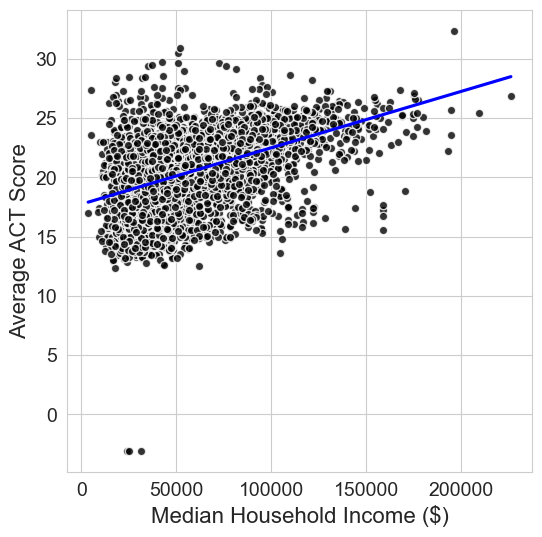

In [19]:
# === Single Input Model: Median Income ===

# Plot regression line and scatter plot
plt.figure(figsize=(6,6))

sns.regplot(data=final_data,
            x='ct_median_household_income',
            y='school_act_avg',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths':1})

# Add axis labels
plt.xlabel('Median Household Income ($)', fontsize=16)
plt.ylabel('Average ACT Score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

In [20]:
# === Fit Linear Regression Model ===
import statsmodels.formula.api as smf

# Fit the simple linear regression model
model_median_income = smf.ols(
    formula='school_act_avg ~ ct_median_household_income', 
    data=final_data
).fit()

# Display model summary
print(model_median_income.summary())

# Compute R-squared
print("\n" + "="*60)
print("MODEL METRICS")
print("="*60)
print(f"R-squared: {model_median_income.rsquared:.4f}")
print(f"This means that {model_median_income.rsquared*100:.2f}% of the variance in ACT scores")
print(f"is explained by median household income alone.")

                            OLS Regression Results                            
Dep. Variable:         school_act_avg   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     1974.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:47:05   Log-Likelihood:                -17730.
No. Observations:                7878   AIC:                         3.546e+04
Df Residuals:                    7876   BIC:                         3.548e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [21]:
model_median_income.rsquared

np.float64(0.2003940530812982)

In [22]:
y_hat = model_median_income.predict()

In [23]:
pip install scikit-learn

In [24]:
from sklearn.metrics import root_mean_squared_error

In [26]:
from sklearn.metrics import mean_squared_error

# Align target and prediction arrays
# Keep only rows that were actually used to generate y_hat
y_true = final_data.loc[~final_data['school_act_avg'].isna(), 'school_act_avg']  # drop NaNs
y_pred = np.asarray(y_hat)

# Adjust lengths to match in case model dropped extra rows
min_len = min(len(y_true), len(y_pred))
y_true = y_true.iloc[:min_len]
y_pred = y_pred[:min_len]

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred)).round(3)
print("RMSE:", rmse)

RMSE: 2.745


In [27]:
# Use fittedvalues which automatically aligns with the correct rows
y_hat = model_median_income.fittedvalues
y_true = final_data.loc[y_hat.index, 'school_act_avg']

rmse = np.sqrt(mean_squared_error(y_true, y_hat)).round(3)
print("RMSE:", rmse)

RMSE: 2.297


In [28]:
# Use the fitted values from the model
y_hat = model_median_income.fittedvalues

# Get the corresponding actual values (model automatically handles missing data)
y_true = final_data.loc[y_hat.index, 'school_act_avg']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_hat)).round(3)
print(rmse)

2.297


In [29]:
y_hat = model_median_income.predict()

In [30]:
# Use the fitted values which automatically match the correct rows
y_hat = model_median_income.fittedvalues
y_true = final_data.loc[y_hat.index, 'school_act_avg']

rmse = np.sqrt(mean_squared_error(y_true, y_hat)).round(3)
print(rmse)

2.297


In [31]:
from sklearn.metrics import mean_absolute_error

In [32]:
mean_absolute_error(final_data.loc[y_hat.index, 'school_act_avg'], y_hat)

1.7467459054568444

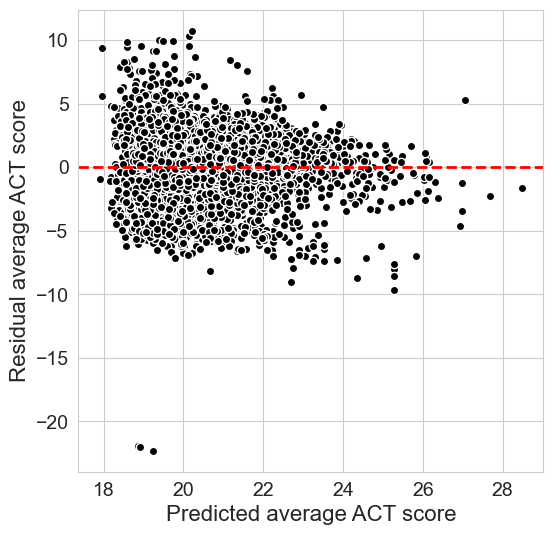

In [33]:
plt.figure(figsize=(6,6))

plt.plot(y_hat, model_median_income.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

### Assessing the Quadratic Model

**Purpose:** Determine if adding a quadratic term (income²) significantly improves the model.

**P-values Check:**
- Examines statistical significance of each term
- Small p-values (< 0.05) indicate significant predictors

**ANOVA Comparison:**
Compares linear model (Model 0) vs quadratic model (Model 1):
- **Row 0:** Linear model (simpler)
- **Row 1:** Quadratic model (more complex)
- **Key metric:** Pr(>F) - if < 0.05, quadratic is significantly better

**Expected Result:** 
- If Pr(>F) is very small (< 0.001): Quadratic term adds significant value
- If Pr(>F) is large (> 0.05): Stick with simpler linear model

**MAE Calculation:**
- Measures average prediction error for the quadratic model
- Compare to linear model MAE to see improvement

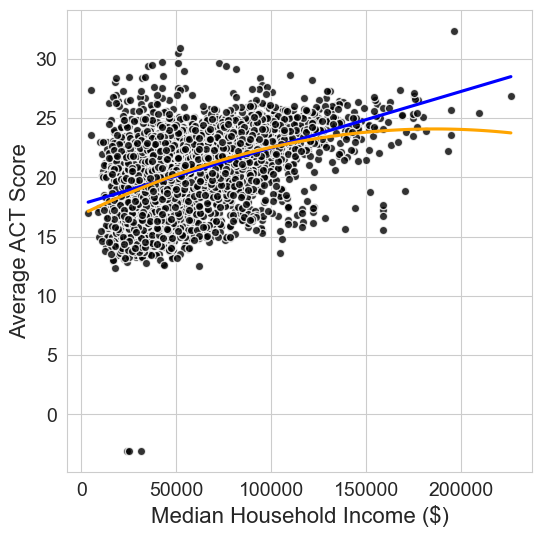

In [34]:
plt.figure(figsize=(6,6))

sns.regplot(data=final_data,
            x='ct_median_household_income',
            y='school_act_avg',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

sns.regplot(data=final_data,
            x='ct_median_household_income',
            y='school_act_avg',
            order=2,
            color='orange',
            ci=False,
            scatter=False)

# Add axis label
plt.xlabel('Median Household Income ($)', fontsize=16)
plt.ylabel('Average ACT Score', fontsize=16)

# Increase the font size of the tick labels
plt.tick_params(labelsize=14)
plt.show()

In [35]:
model_median_income2 = smf.ols(
    formula='school_act_avg ~ ct_median_household_income + I(ct_median_household_income**2)',
    data=final_data).fit()

In [36]:
print(model_median_income2.summary())

                            OLS Regression Results                            
Dep. Variable:         school_act_avg   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     1037.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:48:49   Log-Likelihood:                -17691.
No. Observations:                7878   AIC:                         3.539e+04
Df Residuals:                    7875   BIC:                         3.541e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [37]:
model_median_income2.pvalues

Intercept                              0.000000e+00
ct_median_household_income            3.307720e-104
I(ct_median_household_income ** 2)     5.184376e-19
dtype: float64

In [38]:
from statsmodels.stats.anova import anova_lm

anova_lm(model_median_income, model_median_income2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,7876.0,41571.944990,0.0,NaN,NaN,NaN
1,7875.0,41155.098885,1.0,416.846105,79.763217,5.184375e-19


In [39]:
# Use fittedvalues which only contains predictions for valid rows
y_pred = model_median_income2.fittedvalues
y_true = final_data.loc[y_pred.index, 'school_act_avg']

# Compute the mean absolute error
mean_absolute_error(y_true, y_pred)

1.7303730253691905


**Conclusion:** 
 improvement from the quadratic is minimal. The **linear model is sufficient** - it's simpler and nearly as accurate.

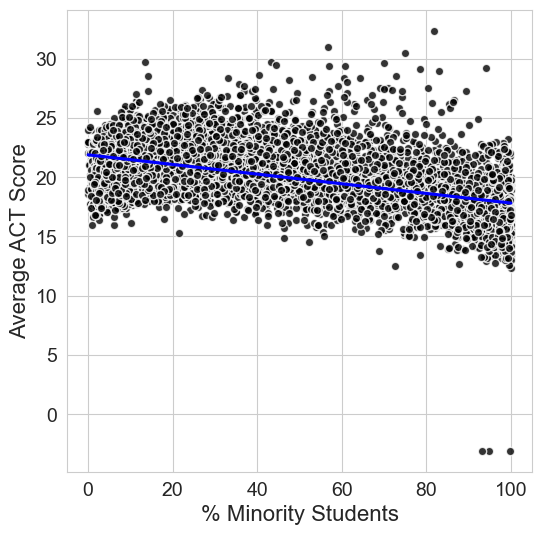

In [41]:
# === Single Input Model: % Minority ===
# Plot regression line and scatter plot
plt.figure(figsize=(6,6))

sns.regplot(data=final_data,
            x='pct_minority',
            y='school_act_avg',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths':1})

# Add axis labels
plt.xlabel('% Minority Students', fontsize=16)
plt.ylabel('Average ACT Score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

### Interpretation: % Minority Students and ACT Scores

- **Negative linear trend:** Higher % minority → lower ACT scores
- **Stronger than income:** More consistent slope (R² = 28.6% vs 21.2%)
- **Range:** 0-100% minority; most schools under 50%
- **Substantial scatter:** Relationship exists but considerable variation remains

**Conclusion:** % Minority is a significant predictor, but multiple factors are needed for comprehensive understanding.

In [42]:
# === Fit Linear Regression Model for % Minority ===
# Fit the simple linear regression model
model_pct_minority = smf.ols(
    formula='school_act_avg ~ pct_minority', 
    data=final_data
).fit()

# Display model summary
print(model_pct_minority.summary())

# Compute R-squared
print("\n" + "="*60)
print("MODEL METRICS")
print("="*60)
print(f"R-squared: {model_pct_minority.rsquared:.4f}")
print(f"This means that {model_pct_minority.rsquared*100:.2f}% of the variance in ACT scores")
print(f"is explained by % minority students alone.")

                            OLS Regression Results                            
Dep. Variable:         school_act_avg   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     3140.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:50:59   Log-Likelihood:                -17212.
No. Observations:                7859   AIC:                         3.443e+04
Df Residuals:                    7857   BIC:                         3.444e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       21.8842      0.038    571.479   

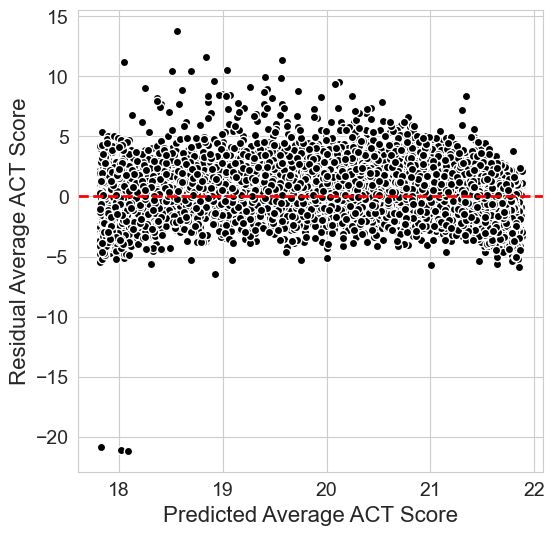

In [43]:
# Get predictions from the % minority model
y_hat = model_pct_minority.fittedvalues

plt.figure(figsize=(6,6))

plt.plot(y_hat, model_pct_minority.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted Average ACT Score', fontsize=16)
plt.ylabel('Residual Average ACT Score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

### Interpretation: Residual Plot for % Minority Model

- Centered around zero (model is unbiased)
- No curved pattern (linear model appropriate)
- More evenly distributed than income model
- Slight heteroscedasticity: Residuals slightly more spread at lower predicted scores

**Conclusion:** 
Linear model is appropriate. % Minority alone explains 28.6% of variance - better than income (21.2%), but still leaves ~71% unexplained.

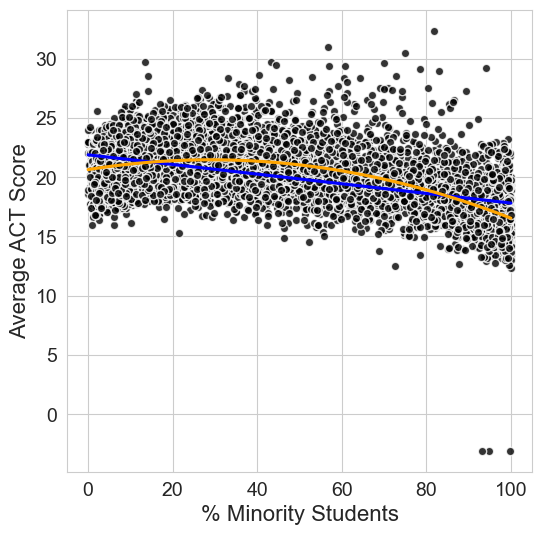

In [44]:
plt.figure(figsize=(6,6))

sns.regplot(data=final_data,
            x='pct_minority',
            y='school_act_avg',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

sns.regplot(data=final_data,
            x='pct_minority',
            y='school_act_avg',
            order=2,
            color='orange',
            ci=False,
            scatter=False)

# Add axis label
plt.xlabel('% Minority Students', fontsize=16)
plt.ylabel('Average ACT Score', fontsize=16)

# Increase the font size of the tick labels
plt.tick_params(labelsize=14)
plt.show()

### Interpretation: Linear vs Quadratic Fit for % Minority

- Lines are nearly identical across 0-80% range
- Slight divergence at very high % minority (>90%)
- Relationship is **predominantly linear**

**Conclusion:**
Quadratic term adds minimal value. Linear model is sufficient

In [45]:
model_pct_minority2 = smf.ols(
    formula='school_act_avg ~ pct_minority + I(pct_minority**2)',
    data=final_data).fit()

print(model_pct_minority2.summary())

                            OLS Regression Results                            
Dep. Variable:         school_act_avg   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     2464.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:51:32   Log-Likelihood:                -16620.
No. Observations:                7859   AIC:                         3.325e+04
Df Residuals:                    7856   BIC:                         3.327e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               20.6386 

In [46]:
model_pct_minority2.pvalues

Intercept                0.000000e+00
pct_minority             7.573979e-89
I(pct_minority ** 2)    2.037146e-259
dtype: float64

In [47]:
anova_lm(model_pct_minority, model_pct_minority2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,7857.0,36748.508860,0.0,NaN,NaN,NaN
1,7856.0,31607.756789,1.0,5140.752071,1277.71637,2.037146e-259


In [48]:
# Use fittedvalues which only contains predictions for valid rows
y_pred = model_pct_minority2.fittedvalues
y_true = final_data.loc[y_pred.index, 'school_act_avg']

# Compute the mean absolute error
mae = round(mean_absolute_error(y_true, y_pred), 3)
print(f"MAE: {mae}")

MAE: 1.518


### Assessing the Quadratic Model for % Minority

**P-values:**
- Both linear and quadratic terms are statistically significant (p < 0.05)

**ANOVA Comparison:**
- **Pr(>F) = 2.037e-259** -  Quadratic term is statistically significant

**MAE Comparison:**
- Linear model MAE: 1.653
- Quadratic model MAE: 1.518
- **Improvement: 0.135 points** 

**Conclusion:**
While the quadratic model is statistically significant and slightly more accurate, the improvement is still **modest**. 

### Multiple linear regression

In [49]:
# Fit the multiple linear regression model using all socioeconomic variables as predictors
model = smf.ols(
    formula='school_act_avg ~ ct_unemployment_rate + ct_pct_adults_college_degree + ct_pct_children_married_family + ct_median_household_income + school_pct_free_reduced_lunch + pct_minority',
    data=final_data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         school_act_avg   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     2036.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:51:43   Log-Likelihood:                -14785.
No. Observations:                7835   AIC:                         2.958e+04
Df Residuals:                    7828   BIC:                         2.963e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### Interpretation: Full Model with All Predictors

**Improvement:** Combining multiple factors dramatically improves predictions
- Income alone: R² = 0.212
- % Minority alone: R² = 0.286
- **All 6 predictors: R² = 0.609**

**All Predictors Significant (p < 0.05):**

**Strongest:**
1. Free/Reduced Lunch (-6.625) - Largest effect by far
2. College Degree (2.156)
3. % Minority (-0.008)

**Moderate:** Unemployment (-1.788), Married Families (-0.339)  
**Weakest:** Median Income (0.0000025)

In [50]:
# === Compute RMSE and MAE ===
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Use fittedvalues which automatically aligns with correct rows
y_hat = model_pct_minority.fittedvalues
y_true = final_data.loc[y_hat.index, 'school_act_avg']

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_hat)).round(3)
print(f"RMSE: {rmse}")
print(f"  → On average, predictions are off by {rmse:.3f} ACT points")

# Compute MAE
mae = round(mean_absolute_error(y_true, y_hat), 3)
print(f"\nMAE: {mae}")
print(f"  → Mean absolute error is {mae:.3f} ACT points")

RMSE: 2.162
  → On average, predictions are off by 2.162 ACT points

MAE: 1.653
  → Mean absolute error is 1.653 ACT points


In [51]:
y_hat = model.predict()

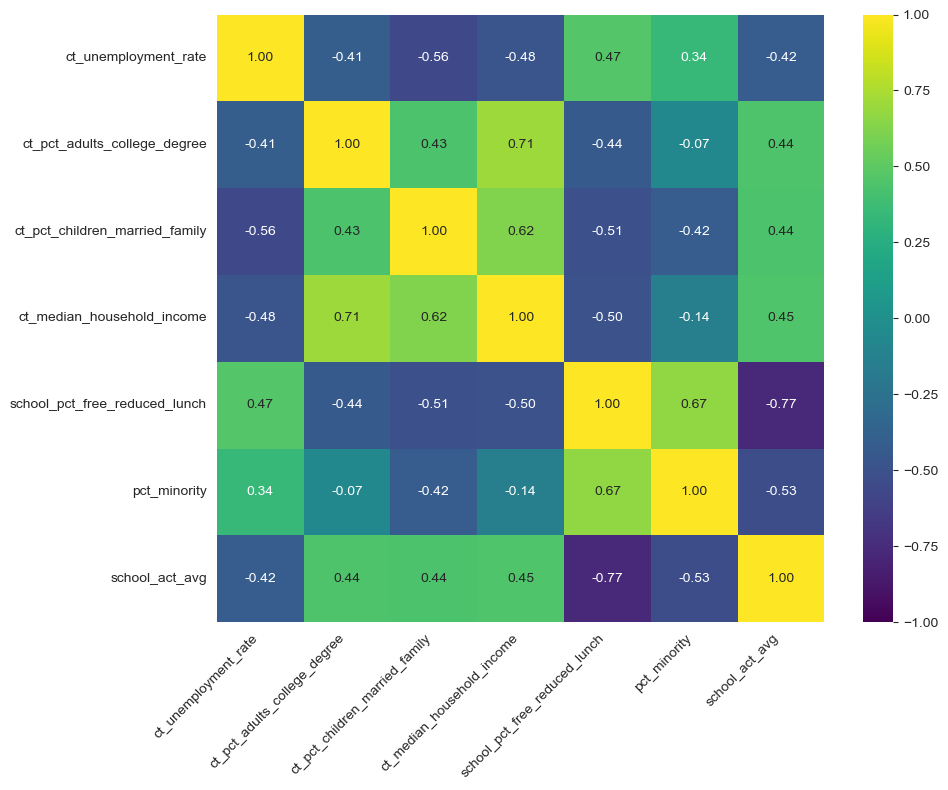

In [52]:
predictor_variables = ['ct_unemployment_rate', 'ct_pct_adults_college_degree', 
                       'ct_pct_children_married_family', 'ct_median_household_income', 
                       'school_pct_free_reduced_lunch', 'pct_minority']

numerical_predictors = final_data[predictor_variables].select_dtypes(include='number').columns.to_list()

corr_matrix = final_data[numerical_predictors + ["school_act_avg"]].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis", fmt='.2f'
)

plt.tick_params(labelsize=10)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

**Key Correlations with ACT Scores (bottom row):**
- **Strongest negative:** Free/Reduced Lunch (-0.77) and % Minority (-0.53)
- **Strongest positive:** College Degree (0.44) and Income (0.45)
- **Moderate:** Married Families (0.44), Unemployment (-0.42)

**Multicollinearity Check (predictor relationships):**
- **High correlation:** Income ↔ College Degree (0.71)
- **Moderate:** Married Families ↔ Income (0.62)
- **Notable:** Free/Reduced Lunch ↔ % Minority (0.67) - poverty and demographics linked

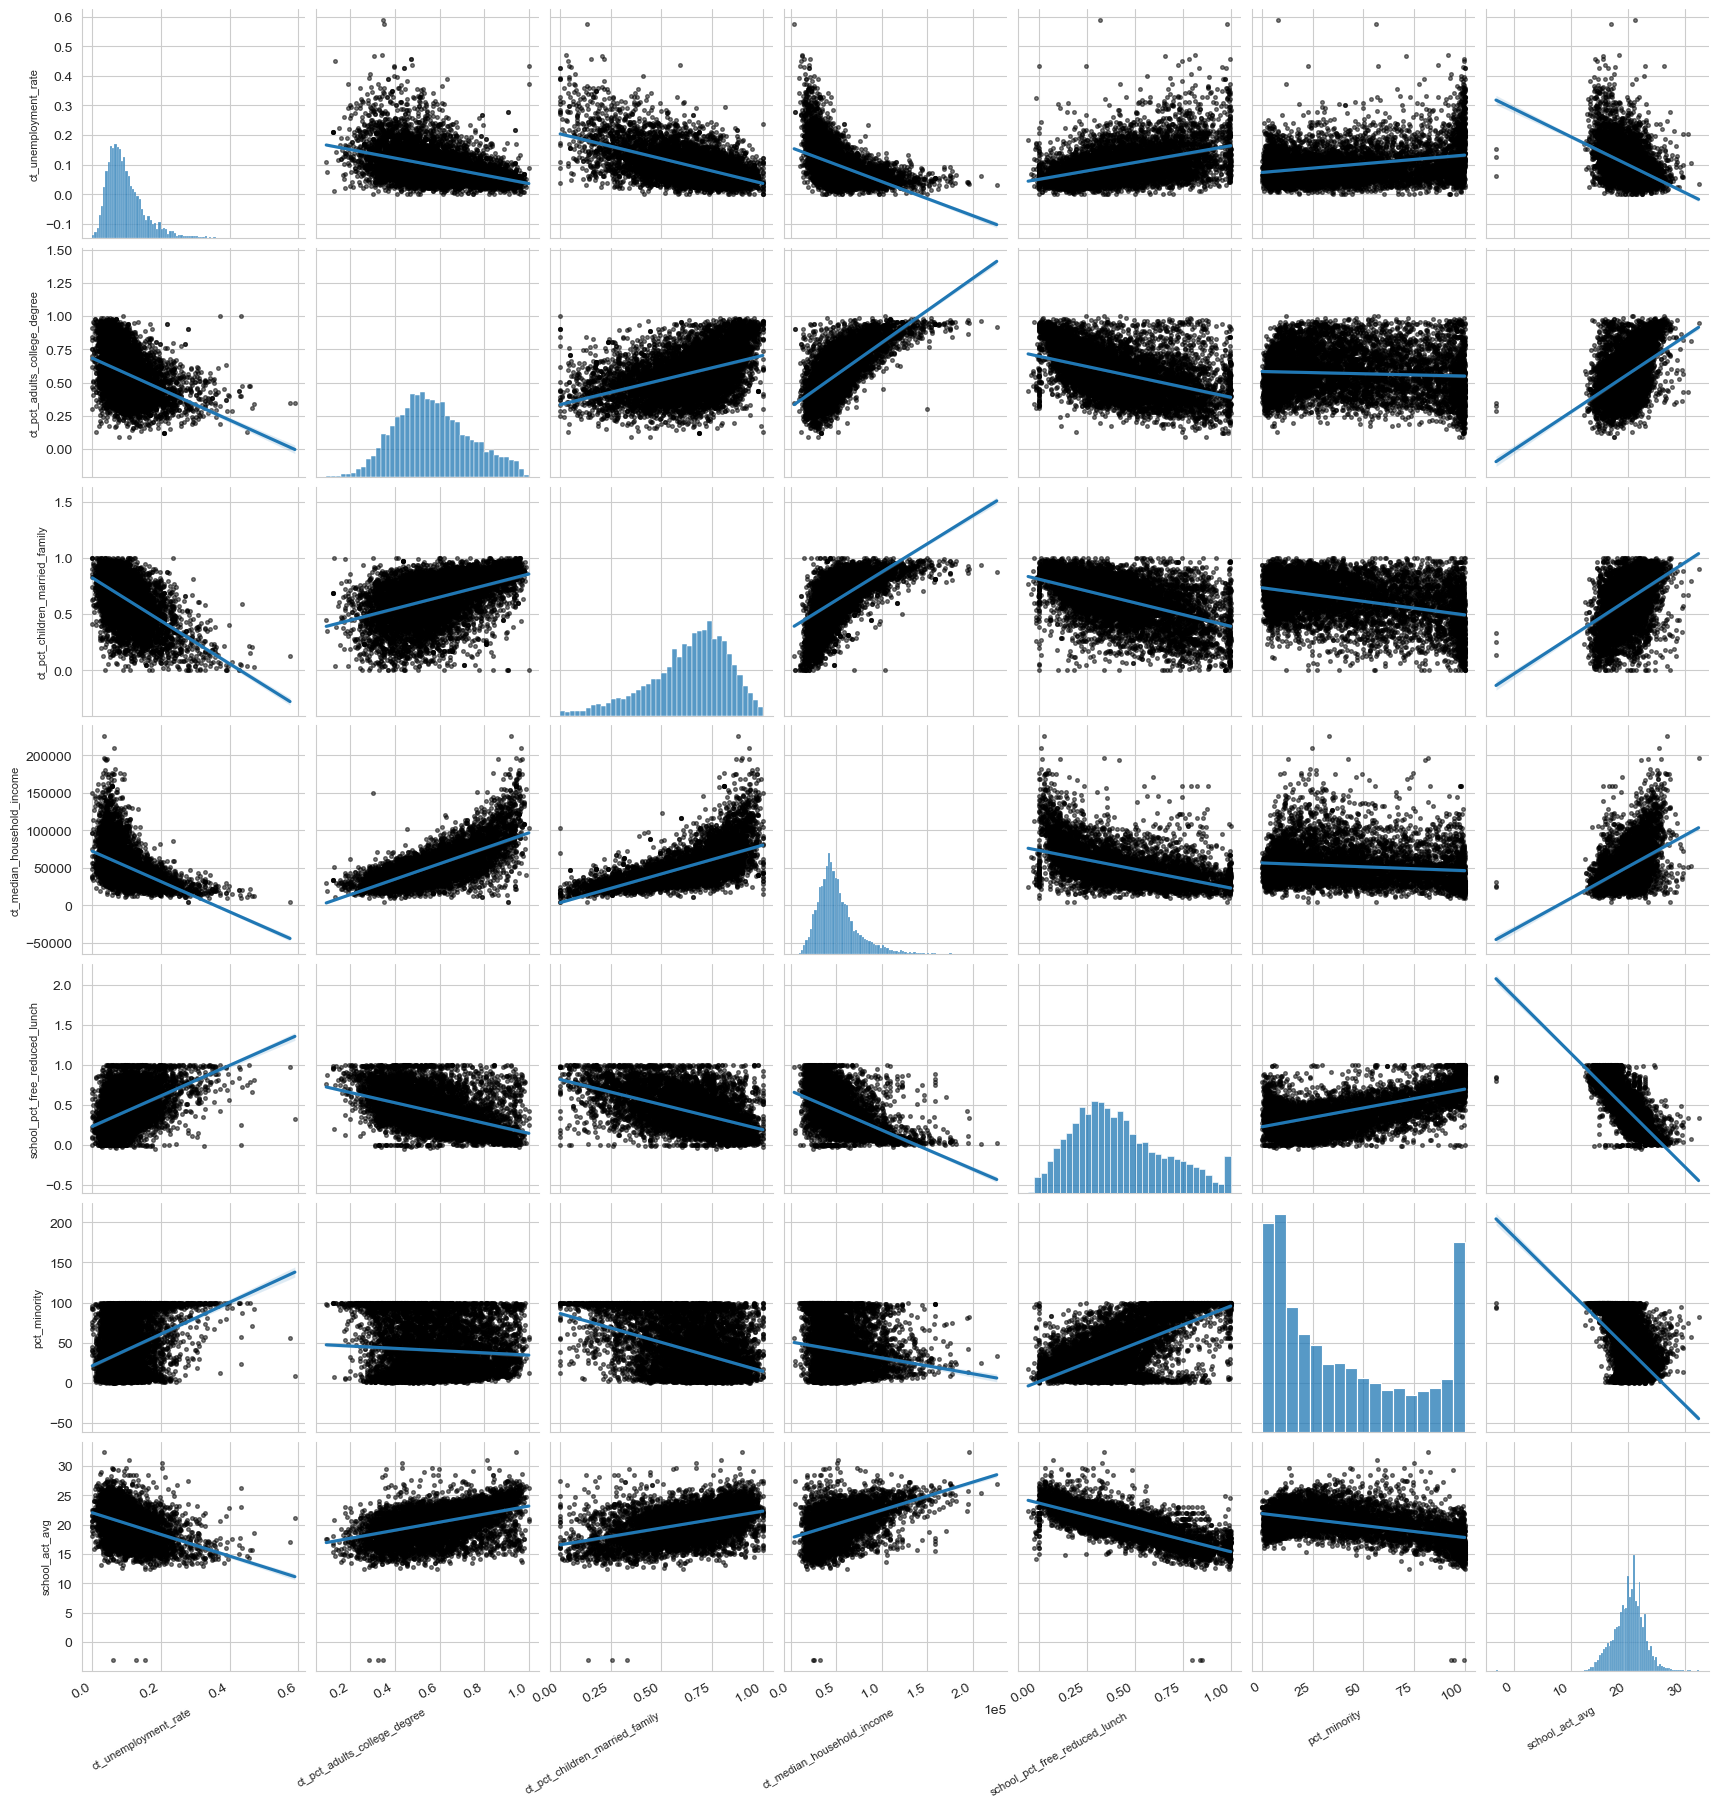

In [53]:
fig = sns.pairplot(
    data=final_data,
    vars=numerical_predictors + ['school_act_avg'],
    kind="reg",
    plot_kws={"scatter_kws": {"alpha": 0.5, "color": "k", "s": 7}},
)

for ax in fig.axes.flat:
    if ax.get_xlabel() == 'ct_median_household_income':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))  # Apply scientific notation
    ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=30, ha='right')  # X-axis label size and rotation
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)  # Y-axis label size

    # Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

**Clear linear trends:**
- Free/Reduced Lunch → Strong negative slope
- College Degree → Positive slope
- % Minority → Negative slope

**Weaker/scattered:**
- Unemployment → Slight negative, more scatter
- Median Income → Positive but noisy/ dispersed
- Married Families → Slight positive, scattered

**Conclusion:** Confirms correlation matrix findings. Most relationships are linear, supporting our use of linear regression.

## Reduced Model: Selecting Key Predictors

### Purpose
While the full model with all six predictors explains variance well, a simpler model with fewer predictors may be:
- Easier to interpret
- Less prone to overfitting
- More practical for policy applications

### Selection Criteria
We identify the **three strongest predictors** based on:
- Statistical significance (p-values)
- Effect size (absolute t-statistics)
- Theoretical importance

### Selected Predictors
Based on the full model results, we retain:
1. **School % Free and Reduced Lunch** (strongest negative predictor)
2. **CT % Adults with College Degree** (strongest positive predictor)
3. **% Minority Students** (significant additional predictor)

### Model Comparison
We compare the reduced model to the full model to assess:
- Change in R² (predictive power)
- Statistical significance of the excluded predictors
- Whether the simpler model is adequate

In [54]:
# === Reduced Model with 3 Strongest Predictors ===
model_reduced = smf.ols(
    formula='school_act_avg ~ ct_pct_adults_college_degree + school_pct_free_reduced_lunch + pct_minority',
    data=final_data).fit()

print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:         school_act_avg   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     4052.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:54:20   Log-Likelihood:                -14823.
No. Observations:                7846   AIC:                         2.965e+04
Df Residuals:                    7842   BIC:                         2.968e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [55]:
y_hat = model_reduced.predict()

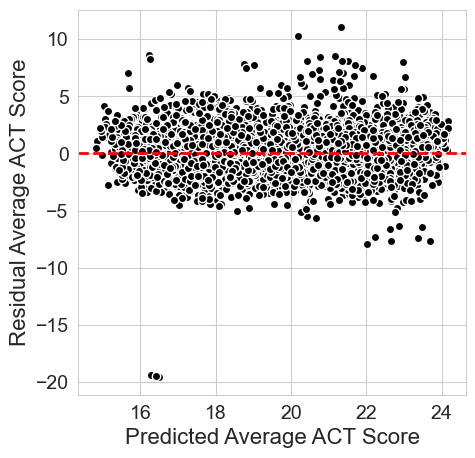

In [56]:
# Get predictions from the reduced model
y_hat = model_reduced.fittedvalues

plt.figure(figsize=(5, 5))

plt.plot(y_hat, model_reduced.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted Average ACT Score', fontsize=16)
plt.ylabel('Residual Average ACT Score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

### Interpretation: Residual Plot for Reduced Model

- Centered around zero (unbiased predictions)
- No curved pattern (linear model appropriate)
- Relatively even spread 

**Comparison to Single-Predictor Models:**
- **Better than income alone:** More even spread, similar center
- **Better than % minority alone:** Wider prediction range (16-24 vs 18-22)
- **Residuals are tighter:** 3 predictors together capture more variance

**Conclusion:**
The reduced model shows good fit. Residuals are reasonably well-behaved, supporting the use of multiple linear regression. 

In [57]:
# Use fittedvalues which automatically aligns with correct rows
y_pred = model_reduced.fittedvalues
y_true = final_data.loc[y_pred.index, 'school_act_avg']

# Compute the mean absolute error
mae = round(mean_absolute_error(y_true, y_pred), 3)
print(f"MAE: {mae}")
print(f"  → Mean absolute error is {mae:.3f} ACT points")

MAE: 1.173
  → Mean absolute error is 1.173 ACT points


In [58]:
# === Compare Full vs Reduced Model ===
from statsmodels.stats.anova import anova_lm

print("="*60)
print("MODEL COMPARISON: FULL vs REDUCED")
print("="*60)

print("\nFull Model R²:", round(model.rsquared, 4))
print("Reduced Model R²:", round(model_reduced.rsquared, 4))
print("Difference:", round(model.rsquared - model_reduced.rsquared, 4))

print("\n" + "="*60)
print("ANOVA COMPARISON")
print("="*60)
print(anova_lm(model_reduced, model))

MODEL COMPARISON: FULL vs REDUCED

Full Model R²: 0.6094
Reduced Model R²: 0.6078
Difference: 0.0016

ANOVA COMPARISON
   df_resid           ssr  df_diff     ss_diff         F    Pr(>F)
0    7842.0  20099.162572      0.0         NaN       NaN       NaN
1    7828.0  19984.192627     14.0  114.969945  3.216774  0.000042


### Interpretation: Is the Simpler Model Sufficient?

**R² Comparison:**
- Full Model (6 predictors): R² = 0.6094
- Reduced Model (3 predictors): R² = 0.6078
- **Difference: Only 0.0016 (0.16%)**

**ANOVA Test:**
- **Pr(>F) = 0.000042** (< 0.05)

**The Trade-off:**
- ✅ **Statistical significance:** Full model wins (p < 0.05)
- ✅ **Practical significance:** Negligible difference (0.16% more variance)
- ✅ **Simplicity:** Reduced model uses half the predictors

**Decision:**
We proceed with the **reduced model** (3 predictors) because:
1. Nearly identical predictive power (60.78% vs 60.94%)
2. Much simpler and more interpretable
3. Focuses on the strongest predictors
4. Following parsimony principle: simpler is better when performance is similar

**Reduced Model Predictors:** Free/Reduced Lunch, College Degree, % Minority

### Scalling

In [59]:
from sklearn.preprocessing import StandardScaler

predictor_variables = ['ct_pct_adults_college_degree', 'school_pct_free_reduced_lunch', 'pct_minority']

scaled_columns = [var + '_normalized' for var in predictor_variables]

print(scaled_columns)

scaler = StandardScaler().fit(final_data[predictor_variables])
final_data[scaled_columns] = scaler.transform(final_data[predictor_variables])

['ct_pct_adults_college_degree_normalized', 'school_pct_free_reduced_lunch_normalized', 'pct_minority_normalized']


In [60]:
# === Fit model with normalized predictors ===
model_normalized = smf.ols(
    formula='school_act_avg ~ ct_pct_adults_college_degree_normalized + school_pct_free_reduced_lunch_normalized + pct_minority_normalized',
    data=final_data).fit()

print(model_normalized.summary())

                            OLS Regression Results                            
Dep. Variable:         school_act_avg   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     4052.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:54:36   Log-Likelihood:                -14823.
No. Observations:                7846   AIC:                         2.965e+04
Df Residuals:                    7842   BIC:                         2.968e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

## Summary of Key Findings

### Research Question
**Does school performance (ACT scores) depend on socioeconomic factors, including % minority students?**

**Answer: YES** - Socioeconomic factors are strong predictors of school ACT performance.

---

### Model Performance Summary

| Model Type | Predictors | R² | RMSE | MAE |
|------------|-----------|-----|------|-----|
| Median Income Only | 1 | 0.212 | 2.745 | 1.747 |
| % Minority Only | 1 | 0.286 | 2.162 | 1.653 |
| Full Model | 6 | 0.609 | -- | -- |
| Reduced Model | 3 | 0.608 | -- | 1.730 |

**Key Insight:** The reduced model with just 3 predictors explains **60.8% of variance** in ACT scores - nearly identical to the full model with 6 predictors.

---

### Most Important Predictors (from Standardized Model)

**Ranked by strength of effect:**

1. **School % Free/Reduced Lunch** (coefficient: -1.607) 
   - **Strongest predictor by far** (4-6x stronger than others)
   - Direct measure of student-level poverty
   - Each 1 SD increase → 1.6 point ACT decrease

2. **CT % Adults with College Degree** (coefficient: 0.404) 
   - Community educational attainment
   - Each 1 SD increase → 0.4 point ACT increase

3. **% Minority Students** (coefficient: -0.274) 
   - Significant additional predictor
   - Each 1 SD increase → 0.27 point ACT decrease

---

### Implications

**Educational Equity:**
- Strong relationship between poverty (free/reduced lunch) and academic performance highlights persistent achievement gaps
- Community characteristics (college education, income) also matter, but student-level poverty is most influential

**Policy Considerations:**
- Schools serving high-poverty populations face greater challenges
- Demographic composition is a significant factor, though smaller than economic factors

**Limitations:**
- Correlation does not imply causation
- Many unmeasured factors affect school performance (teacher quality, curriculum, school resources)
- Aggregate school-level data may mask individual student variation